# Notebook to illustrate how the $\texttt{WF4Py}$ package works and compare it to $\texttt{LAL}$, making the plots in Fig. 2 and 3 of <a href=https://arxiv.org/abs/2207.06910>arXiv:2207.06910</a>

## Note: to fully use this notebook a working installation of the packages $\texttt{matplotlib}$, $\texttt{astropy}$ and $\texttt{PyCBC}$ is needed

## First import some libraries

In [38]:
import numpy as np

import time
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
rc('text', usetex=True)

from astropy.cosmology import Planck18


from WF4Py import waveforms as WF
from WF4Py import WFutils as utils


ourcodenameString = 'WF4Py'

import pycbc.waveform
import pycbc.types as pcbcdt

In [39]:
def m1m2_from_Mceta(Mc, eta):
    # Define a function to compute the component masses of a binary given its chirp mass and symmetric mass ratio
    m1 = 0.5*(Mc/(eta**(3./5.)))*(1.+np.sqrt(1.-4.*eta))
    m2 = 0.5*(Mc/(eta**(3./5.)))*(1.-np.sqrt(1.-4.*eta))
    
    return m1, m2

## Now we show how to use $\texttt{WF4Py}$

### It is sufficient to choose the parameters of the source(s) to simulate and put them in a dictionary with the correct keys, e.g.

In [218]:
zs = np.array([.2])

events = {'Mc':np.array([30])*(1.+zs), 'dL':(Planck18.luminosity_distance(zs).value/1000.), 
         'iota':np.array([1.]), 'eta':np.array([0.24]), 'chi1z':np.array([0.8]), 'chi2z':np.array([-0.8]), 
        #   'Lambda1':np.array([0.]), 'Lambda2':np.array([0.]), 
          # 'Phicoal':np.array([np.pi/3.]),
          }

### But it is also possible to provide the component masses through the keys $\color{red}{\rm 'm1'}$ and $\color{red}{\rm 'm2'}$, the symmetric and antisymmetric spin components through the keys $\color{red}{\rm 'chiS'}$ and $\color{red}{\rm 'chiA'}$ and the combinations of adimensional tidal deformability parameters $\tilde{\Lambda}, \delta\tilde{\Lambda}$, defined in <a href=https://arxiv.org/abs/1402.5156>arXiv:1402.5156</a>, through the keys  $\color{red}{\rm 'LambdaTilde'}$ and $\color{red}{\rm 'deltaLambda'}$

### Remember to express the masses in units of $M_{\odot}$, and the luminosity distance in $\rm Gpc$

### Let us start with the model $\texttt{IMRPhenomD}$, and reproduce the corresponding plot of comparison with $\texttt{LAL}$
### First we initialise the waveform, compute the maximum frequency, and build the frequency grid...

In [219]:
tmpWF = WF.IMRPhenomD()

fcut = tmpWF.fcut(**events)
fminarr = np.full(fcut.shape, 5)
fgrids = np.geomspace(fminarr, fcut, num=int(1000))

fcut, fminarr

(array([479.07632324]), array([5]))

### ... then computing the amplitude and phase of the gravitational wave signal produced by this system according to the chosen waveform model is as easy as

In [220]:
myampl = tmpWF.Ampl(fgrids, **events)
myphase = tmpWF.Phi(fgrids, **events)

### We then build the same signal also with $\texttt{LAL}$ through $\texttt{PyCBC}$, and plot the two

In [223]:
m1s, m2s = m1m2_from_Mceta(events['Mc'], events['eta'])

hp, hc = pycbc.waveform.get_fd_waveform_sequence(approximant='IMRPhenomD',                                        
                                                    mass1=m1s,
                                                    mass2=m2s,
                                                    spin1z=events['chi1z'],
                                                    spin2z=events['chi2z'],
                                                    sample_points = pcbcdt.array.Array(fgrids[:,0]),
                                                    distance=events['dL']*1000.,
                                                    inclination=events['iota'],
                                                    coa_phase = 0)

PyCBCwfAmpl = np.array(abs(hc))
PyCBCwfPhase = -1.j * np.array(hc/abs(hc))

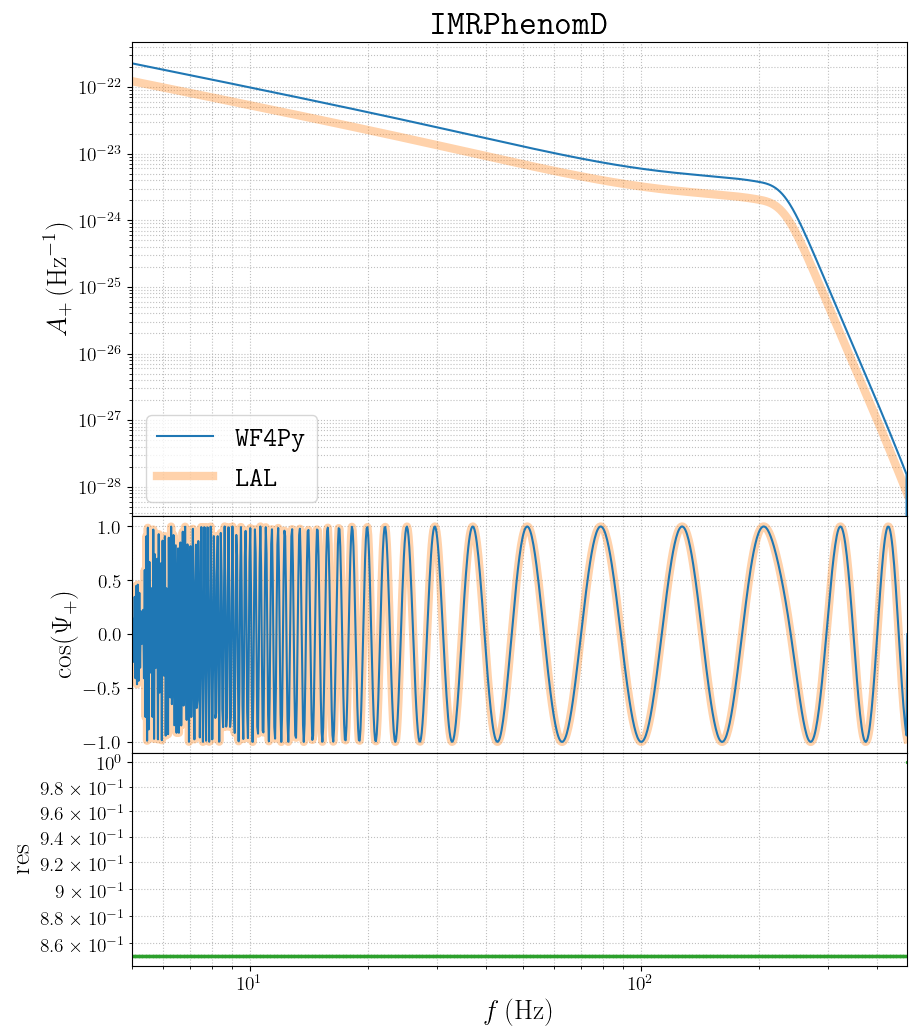

In [224]:
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(3,1,height_ratios=[2,1,.9])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
ax3 = plt.subplot(gs[2], sharex=ax1)
ax1.plot(fgrids, PyCBCwfAmpl, 'C1', label=r'$\texttt{LAL}$', alpha=.35, linewidth=6.)
ax1.plot(fgrids, myampl, 'C0', label=r'$\texttt{%s}$'%ourcodenameString)
ax1.set_yscale('log')
ax1.set_ylabel(r'$A_+ \, ({\rm Hz}^{-1})$',fontsize=20)
ax1.grid()
ax2.plot(fgrids, PyCBCwfPhase.imag, 'C1', alpha=.35, linewidth=6.)
ax2.plot(fgrids[:,0], np.sin(myphase[:,0]), 'C0',)
ax2.set_ylabel(r'$\cos(\Psi_{+})$', fontsize=20)
plt.xlabel(r'$f \, (\rm Hz)$', fontsize=20)
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
ax3.plot(fgrids[:,0], abs(1.-(myampl[:,0])/(PyCBCwfAmpl)), '.', color='C2', ms=3)
ax3.set_ylabel(r'$\rm res$', fontsize=20)
ax1.set_xscale('log')
ax3.set_yscale('log')

plt.subplots_adjust(hspace=0.)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='lower left', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='minor', labelsize=14)

plt.xlim(min(fgrids), max(fgrids))
ax1.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax2.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax3.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)

ax1.set_title(r"{$\bf \texttt{IMRPhenomD}$}", fontsize=25)

plt.show()


### The discrepancy mainly arises from a difference between $\texttt{C}$ and $\texttt{Python}$ in the interpolation needed to compute the ringdown frequency
### The proof for this can be obtained using the $\texttt{IMRPhenomXAS}$ waveform model, which does not rely on any inyerpolation.
### Using the same event as before

In [8]:
# Note that this model has various versions for both the phase and the amplitude
tmpWF = WF.IMRPhenomXAS(InsPhaseVersion=104, IntPhaseVersion=105, IntAmpVersion=104)

fcut = tmpWF.fcut(**events)
fminarr = np.full(fcut.shape, 5)
fgrids = np.geomspace(fminarr, fcut, num=int(1000))

myampl = tmpWF.Ampl(fgrids, **events)
myphase = tmpWF.Phi(fgrids, **events)

In [9]:
m1s, m2s = m1m2_from_Mceta(events['Mc'], events['eta'])

hp, hc = pycbc.waveform.get_fd_waveform_sequence(approximant='IMRPhenomXAS',                                        
                                                    mass1=m1s,
                                                    mass2=m2s,
                                                    spin1z=events['chi1z'],
                                                    spin2z=events['chi2z'],
                                                    sample_points = pcbcdt.array.Array(fgrids[:,0]),
                                                    distance=events['dL']*1000.)

PyCBCwfAmpl = np.array(abs(hp))
PyCBCwfPhase = np.array(hp/abs(hp))

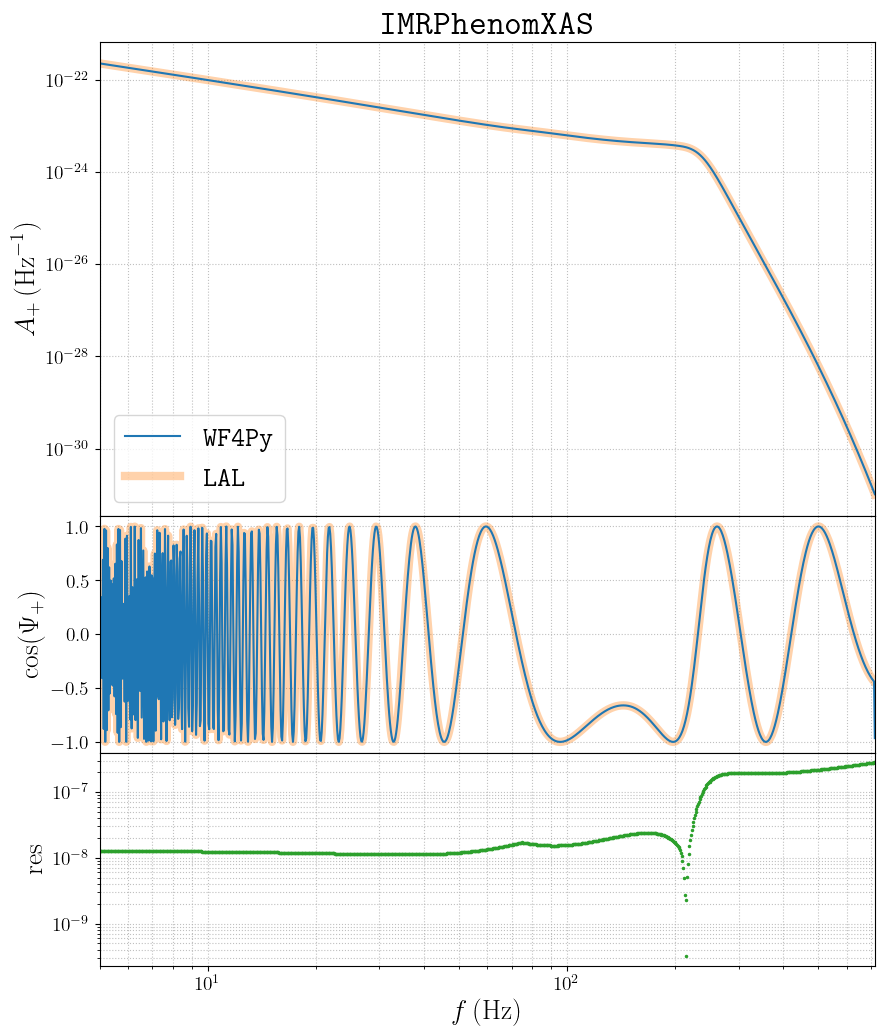

In [10]:
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(3,1,height_ratios=[2,1,.9])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
ax3 = plt.subplot(gs[2], sharex=ax1)
ax1.plot(fgrids, PyCBCwfAmpl, 'C1', label=r'$\texttt{LAL}$', alpha=.35, linewidth=6.)
ax1.plot(fgrids, myampl, 'C0', label=r'$\texttt{%s}$'%ourcodenameString)
ax1.set_yscale('log')
ax1.set_ylabel(r'$A_+ \, ({\rm Hz}^{-1})$',fontsize=20)
ax1.grid()
ax2.plot(fgrids, PyCBCwfPhase.real, 'C1', alpha=.35, linewidth=6.)
ax2.plot(fgrids[:,0], np.cos(myphase[:,0]), 'C0',)
ax2.set_ylabel(r'$\cos(\Psi_{+})$', fontsize=20)
plt.xlabel(r'$f \, (\rm Hz)$', fontsize=20)
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
ax3.plot(fgrids[:,0], abs(1.-(myampl[:,0])/(PyCBCwfAmpl)), '.', color='C2', ms=3)
ax3.set_ylabel(r'$\rm res$', fontsize=20)
ax1.set_xscale('log')
ax3.set_yscale('log')

plt.subplots_adjust(hspace=0.)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='lower left', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='minor', labelsize=14)

plt.xlim(min(fgrids), max(fgrids))
ax1.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax2.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax3.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)

ax1.set_title(r"{$\bf \texttt{IMRPhenomXAS}$}", fontsize=25)

plt.show()

### Now the two agree almost at machine precision!

### Running on multiple events, which is not possible in $\texttt{PyCBC}$ being based on a $\texttt{C}$ code, is as easy as

In [11]:
zs = np.array([.2, .5, .7])

events = {'Mc':np.array([30, 45, 60])*(1.+zs), 
          'dL':(Planck18.luminosity_distance(zs).value/1000.), 
          'iota':np.array([.0, .4, np.pi]), 
          'eta':np.array([0.24, .23, .2499]), 
          'chi1z':np.array([0.8, .5, 0.]), 
          'chi2z':np.array([-0.8, 0., -.2]),}

In [12]:
tmpWF = WF.IMRPhenomD()

fcut = tmpWF.fcut(**events)
print('The cut frequencies are computed all together, and are %s'%fcut)
fminarr = np.full(fcut.shape, 5)
fgrids = np.geomspace(fminarr, fcut, num=int(1000))
print('Notice also that now there is one grid per event, thus fgrids has shape %s'%str(fgrids.shape))

The cut frequencies are computed all together, and are [479.07632324 249.06539571 173.23675714]
Notice also that now there is one grid per event, thus fgrids has shape (1000, 3)


In [13]:
myampl = tmpWF.Ampl(fgrids, **events)
myphase = tmpWF.Phi(fgrids, **events)
print('Now thus myampl and myphase contain amplitudes and phases for all the events, having the same shape as fgrids, i.e. %s'%str(myampl.shape))

Now thus myampl and myphase contain amplitudes and phases for all the events, having the same shape as fgrids, i.e. (1000, 3)


### Now we can do the same for $\texttt{IMRPhenomD_NRTidalv2}$, including also the tidal deformabilities

In [14]:
zs = np.array([.1])
events = {'Mc':np.array([1.2])*(1.+zs), 'dL':(Planck18.luminosity_distance(zs).value/1000.), 
          'iota':np.array([.0]), 'eta':np.array([0.25]), 'chi1z':np.array([0.05]), 'chi2z':np.array([0.]), 
          'Lambda1':np.array([500.]), 'Lambda2':np.array([500.])}

In [15]:
tmpWF = WF.IMRPhenomD_NRTidalv2()

fcut = tmpWF.fcut(**events)
fcut = np.where(fcut>2055, 2055, fcut) 
fminarr = np.full(fcut.shape, 5)
fgrids = np.geomspace(fminarr, fcut, num=int(1000))

print(fcut)

[2055.]


In [16]:
myampl = tmpWF.Ampl(fgrids, **events)
myphase = tmpWF.Phi(fgrids, **events)

In [17]:
m1s, m2s = m1m2_from_Mceta(events['Mc'], events['eta'])

hp, hc = pycbc.waveform.get_fd_waveform_sequence(approximant='IMRPhenomD_NRTidalv2',                                        
                                                    mass1=m1s,
                                                    mass2=m2s,
                                                    spin1z=events['chi1z'],
                                                    spin2z=events['chi2z'],
                                                    lambda1=float(events['Lambda1']),
                                                    lambda2=float(events['Lambda2']),
                                                    sample_points = pcbcdt.array.Array(fgrids[:,0]),
                                                    distance=events['dL']*1000.)

PyCBCwfAmpl = np.array(abs(hp))
PyCBCwfPhase = np.array(hp/abs(hp))

/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_74387/1589758516.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lambda1=float(events['Lambda1']),
/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_74387/1589758516.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lambda2=float(events['Lambda2']),


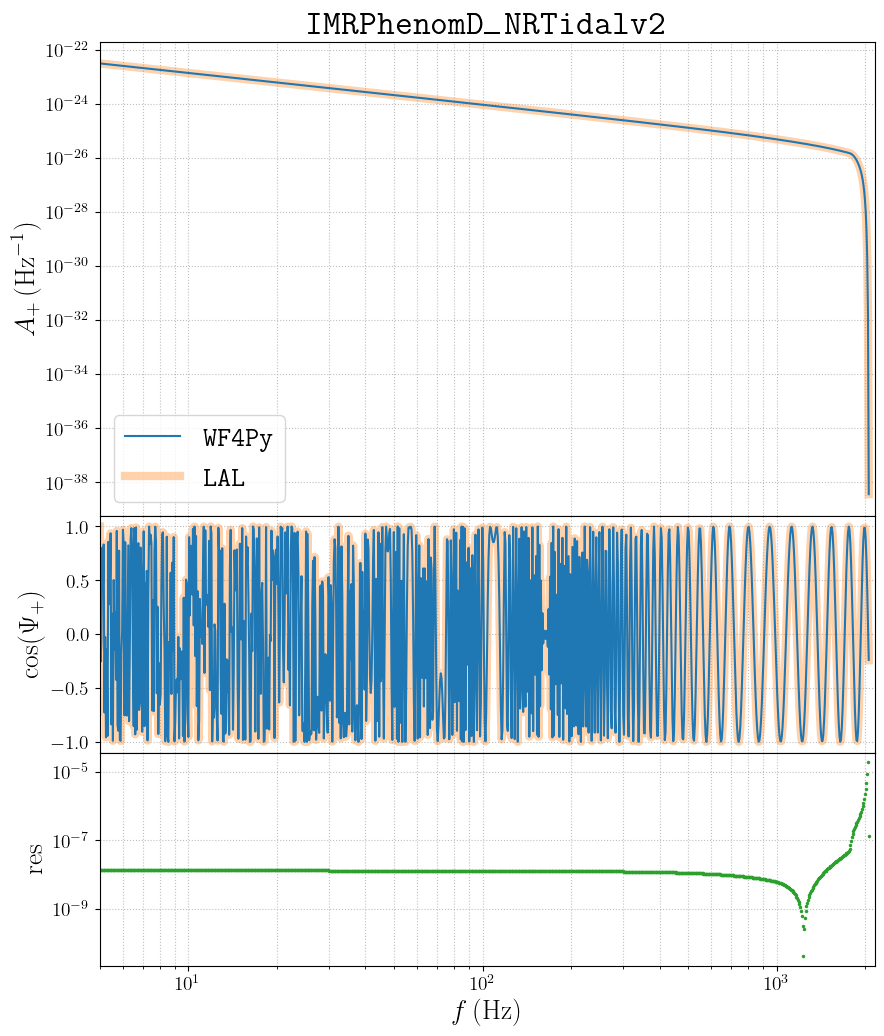

In [18]:
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(3,1,height_ratios=[2,1,.9])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
ax3 = plt.subplot(gs[2], sharex=ax1)
ax1.plot(fgrids, PyCBCwfAmpl, 'C1', label=r'$\texttt{LAL}$', alpha=.35, linewidth=6.)
ax1.plot(fgrids, myampl, 'C0', label=r'$\texttt{%s}$'%ourcodenameString)
ax1.set_yscale('log')
ax1.set_ylabel(r'$A_+ \, ({\rm Hz}^{-1})$',fontsize=20)
ax1.grid()
ax2.plot(fgrids, PyCBCwfPhase.real, 'C1', alpha=.35, linewidth=6.)
ax2.plot(fgrids[:,0], np.cos(myphase[:,0]), 'C0',)
ax2.set_ylabel(r'$\cos(\Psi_{+})$', fontsize=20)
plt.xlabel(r'$f \, (\rm Hz)$', fontsize=20)
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
ax3.plot(fgrids[:,0], abs(1.-(myampl[:,0])/(PyCBCwfAmpl)), '.', color='C2', ms=3)
ax3.set_ylabel(r'$\rm res$', fontsize=20)
ax1.set_xscale('log')
ax3.set_yscale('log')

plt.subplots_adjust(hspace=0.)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='lower left', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='minor', labelsize=14)

plt.xlim(min(fgrids), max(fgrids)+100)
ax1.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax2.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax3.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)

ax1.set_title(r"{$\bf \texttt{IMRPhenomD\rule{.4cm}{1pt}\,NRTidalv2}$}", fontsize=25)

plt.show()

### Now we switch to $\texttt{IMRPhenomHM}$, which includes the contribution of sub-dominant modes, being thus more delicate
#### In this case passing the inclination angle is compulsory

In [205]:
zs = np.array([.1])
events = {'Mc':np.array([40])*(1.+zs), 'dL':(Planck18.luminosity_distance(zs).value/1000.), 
         'iota':np.array([.3]), 'eta':np.array([0.24]),'chi1z':np.array([0.8]), 'chi2z':np.array([0.8]),
         'Phicoal':np.array([np.pi/4.])}

In [206]:
tmpWF = WF.IMRPhenomHM()

fcut = tmpWF.fcut(**events)
fminarr = np.full(fcut.shape, 5)
fgrids = np.geomspace(fminarr, fcut, num=int(1000))

fcut

array([391.97153719])

### In this case we can proceed as before, but the outputs will be dictionaries conaining the amplitudes and phases of the various modes

myampl is a dictionary with dict_keys(['21', '22', '32', '33', '43', '44'])


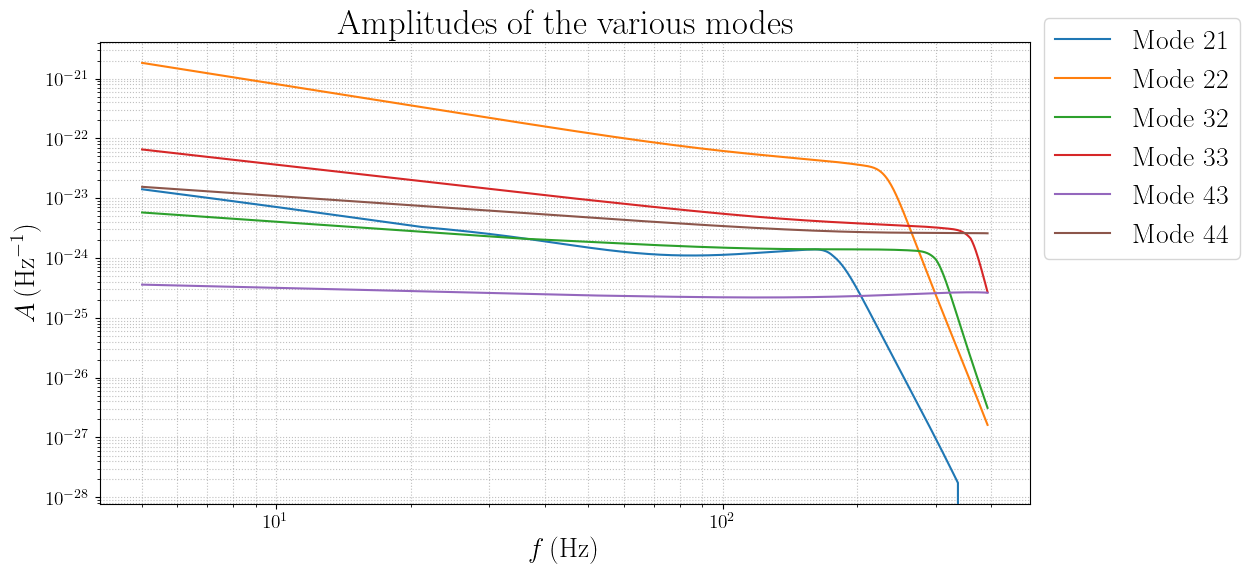

In [207]:
myampl = tmpWF.Ampl(fgrids, **events)
myphase = tmpWF.Phi(fgrids, **events)

print('myampl is a dictionary with '+str(myampl.keys()))
fig, ax = plt.subplots(figsize=(12,6))
for key in myampl.keys():
    ax.plot(fgrids, myampl[key], label=r'${\rm Mode} \ %s$'%key)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax.set_title(r"\textrm{Amplitudes of the various modes}", fontsize=25)
ax.legend(loc='lower left', fontsize=20, bbox_to_anchor=(1, 0.5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlabel(r'$f \, (\rm Hz)$', fontsize=20)
ax.set_ylabel(r'$A \, ({\rm Hz}^{-1})$',fontsize=20)

plt.show()

### It is then possible to combine all the modes with the provided function

In [208]:
myhp, myhc = utils.Add_Higher_Modes(myampl, myphase, events['iota'], phi=events['Phicoal'])

myampl = np.abs(myhp)
myphase = (myhp/myampl).real

### Given the bigger amount of time needed to compute higher modes, we also provide a faster implementation, fully vectorised, which does not rely on for loops, and can be of fundamental importance when dealing with large catalogs

In [209]:
%%time
myhp, myhc = tmpWF.hphc(fgrids, **events)
myampl = np.abs(myhp)
myphase = (myhp/myampl).real

CPU times: user 5.92 ms, sys: 1 ms, total: 6.92 ms
Wall time: 6.3 ms


In [210]:
m1s, m2s = m1m2_from_Mceta(events['Mc'], events['eta'])

hp, hc = pycbc.waveform.get_fd_waveform_sequence(approximant='IMRPhenomHM',                                        
                                                    mass1=m1s,
                                                    mass2=m2s,
                                                    spin1z=events['chi1z'],
                                                    spin2z=events['chi2z'],
                                                    inclination= events['iota'],
                                                    sample_points = pcbcdt.array.Array(fgrids[:,0]),
                                                    distance=events['dL']*1000.,
                                                    coa_phase=events['Phicoal'])

PyCBCwfAmpl = np.array(abs(hp))
PyCBCwfPhase = np.array(hp/abs(hp))

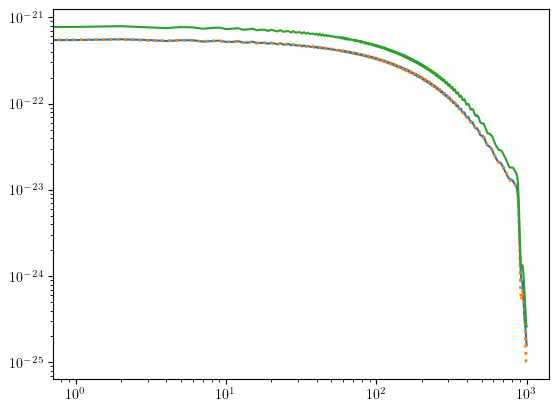

In [211]:
plt.loglog(np.abs(hc))
plt.loglog(np.abs(myhc[:,0]), linestyle=':', linewidth=2)
plt.loglog(np.abs(myhc[:,0]-hc))

# plt.loglog(np.abs(hp), linestyle=':')
# plt.loglog(np.abs(myhp[:,0]-hp), linestyle=':')

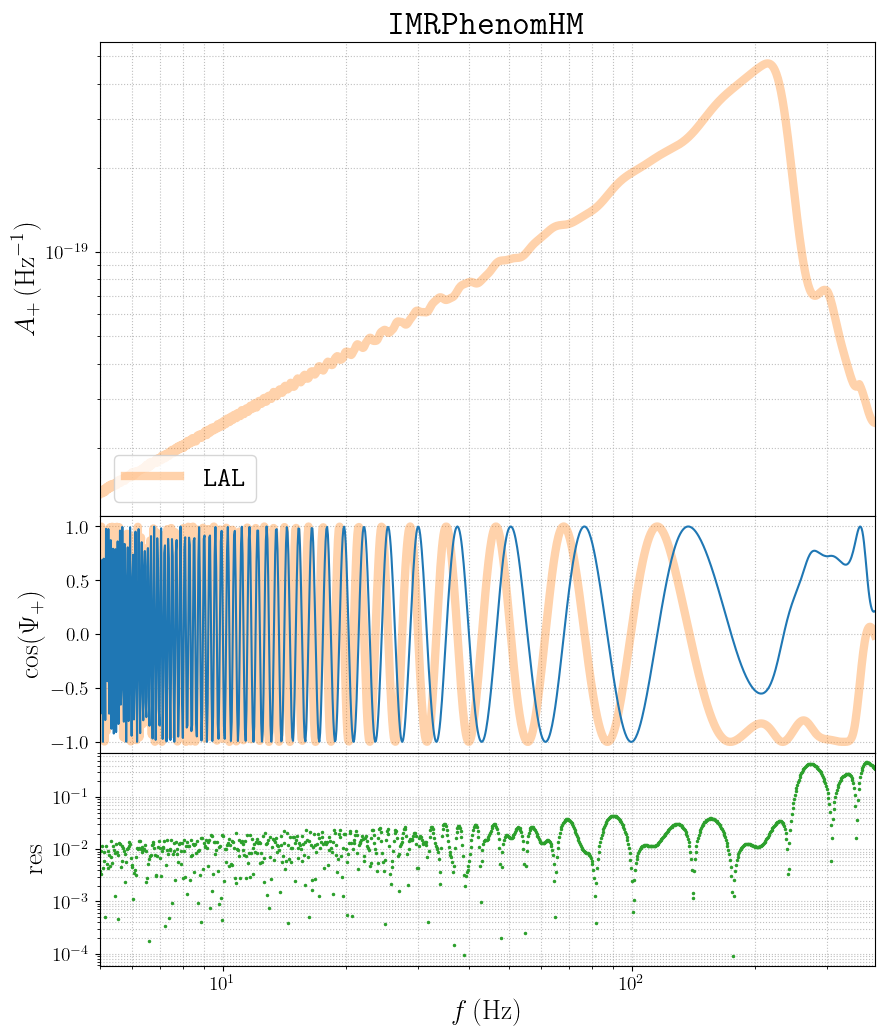

In [212]:
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(3,1,height_ratios=[2,1,.9])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
ax3 = plt.subplot(gs[2], sharex=ax1)
ax1.plot(fgrids[:, 0], PyCBCwfAmpl * fgrids[:, 0] ** 2, 'C1', label=r'$\texttt{LAL}$', alpha=.35, linewidth=6.)
# ax1.plot(fgrids, myampl, 'C0', label=r'$\texttt{%s}$'%ourcodenameString)
ax1.set_yscale('log')
ax1.set_ylabel(r'$A_+ \, ({\rm Hz}^{-1})$',fontsize=20)
ax1.grid()
ax2.plot(fgrids, PyCBCwfPhase.real, 'C1', alpha=.35, linewidth=6.)
ax2.plot(fgrids[:,0], myphase[:,0], 'C0',)
ax2.set_ylabel(r'$\cos(\Psi_{+})$', fontsize=20)
plt.xlabel(r'$f \, (\rm Hz)$', fontsize=20)
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
ax3.plot(fgrids[:,0], abs(1.-(myampl[:,0])/(PyCBCwfAmpl)), '.', color='C2', ms=3)
ax3.set_ylabel(r'$\rm res$', fontsize=20)
ax1.set_xscale('log')
ax3.set_yscale('log')

plt.subplots_adjust(hspace=0.)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='lower left', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='minor', labelsize=14)
plt.xlim(min(fgrids), max(fgrids))
ax1.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax2.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax3.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)

ax1.set_title(r"{$\bf \texttt{IMRPhenomHM}$}", fontsize=25)

plt.show()

In [165]:
np.cos(2. * np.pi / 3.)

-0.49999999999999983

### Finally we use $\texttt{IMRPhenomNSBH}$

In [26]:
zs = np.array([.2])
events = {'Mc':np.array([3.5])*(1.+zs), 'dL':(Planck18.luminosity_distance(zs).value/1000.), 
          'iota':np.array([.0]),'eta':np.array([0.08]), 'chi1z':np.array([0.3]), 'chi2z':np.array([0.]), 
          'Lambda1':np.array([0.]), 'Lambda2':np.array([400.])}

In [27]:
tmpWF = WF.IMRPhenomNSBH()

fcut = tmpWF.fcut(**events)
fminarr = np.full(fcut.shape, 5)
fgrids = np.geomspace(fminarr, fcut, num=int(1000))

print(fcut)

Pre-computed xi_tide grid is present. Loading...
Attributes of pre-computed grid: 
[('Compactness_min', 0.1), ('npoints', 200), ('q_max', 100.0)]
[2124.14991938]


In [28]:
myampl = tmpWF.Ampl(fgrids, **events)
myphase = tmpWF.Phi(fgrids, **events)



In [29]:
Mtot = events['Mc']/(events['eta']**(3./5.))
m1s, m2s = m1m2_from_Mceta(events['Mc'], events['eta'])

hp, hc = pycbc.waveform.get_fd_waveform_sequence(approximant='IMRPhenomNSBH',                                        
                                                    mass1=m1s,
                                                    mass2=m2s,
                                                    spin1z=events['chi1z'],
                                                    spin2z=events['chi2z'],
                                                    lambda2=float(events['Lambda2']),
                                                    sample_points = pcbcdt.array.Array(fgrids[:,0]),
                                                    distance=events['dL']*1000.)

PyCBCwfAmpl = np.array(abs(hp))
PyCBCwfPhase = np.array(hp/abs(hp))

/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_74387/1292801420.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lambda2=float(events['Lambda2']),


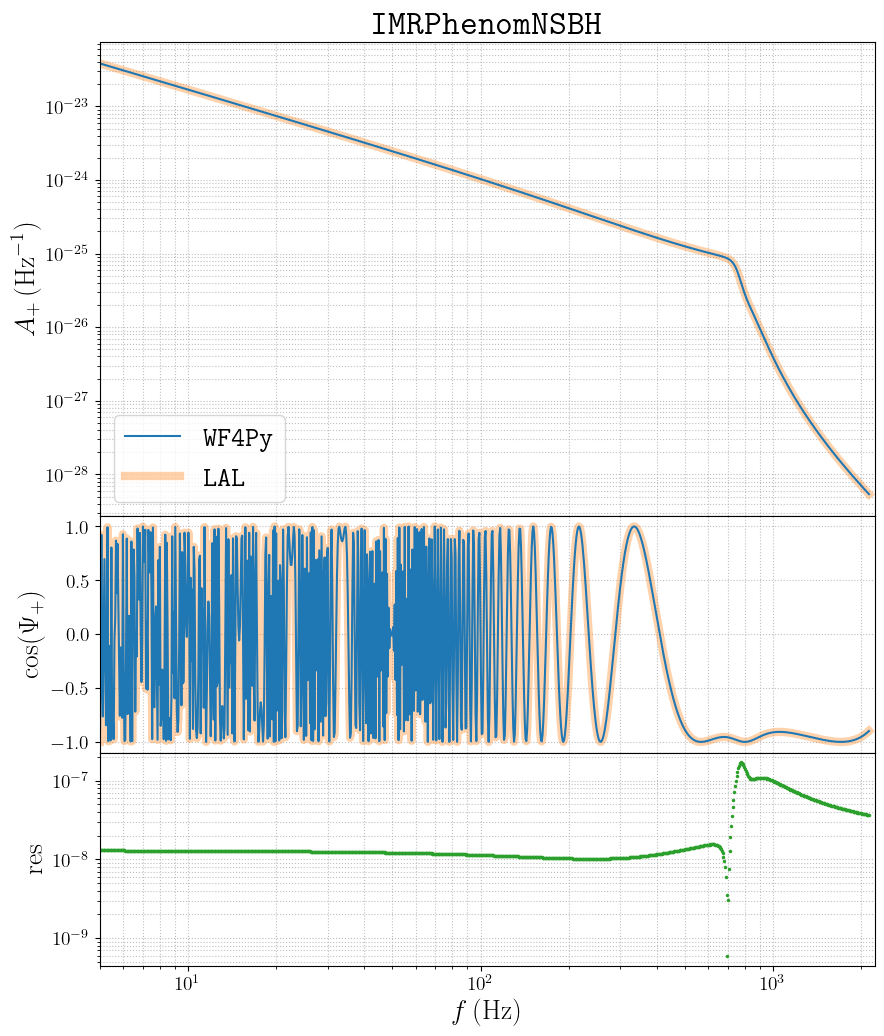

In [30]:
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(3,1,height_ratios=[2,1,.9])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
ax3 = plt.subplot(gs[2], sharex=ax1)
ax1.plot(fgrids, PyCBCwfAmpl, 'C1', label=r'$\texttt{LAL}$', alpha=.35, linewidth=6.)
ax1.plot(fgrids, myampl, 'C0', label=r'$\texttt{%s}$'%ourcodenameString)
ax1.set_yscale('log')
ax1.set_ylabel(r'$A_+ \, ({\rm Hz}^{-1})$',fontsize=20)
ax1.grid()
ax2.plot(fgrids, PyCBCwfPhase.real, 'C1', alpha=.35, linewidth=6.)
ax2.plot(fgrids[:,0], np.cos(myphase[:,0]), 'C0',)
ax2.set_ylabel(r'$\cos(\Psi_{+})$', fontsize=20)
plt.xlabel(r'$f \, (\rm Hz)$', fontsize=20)
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
ax3.plot(fgrids[:,0], abs(1.-(myampl[:,0])/(PyCBCwfAmpl)), '.', color='C2', ms=3)
ax3.set_ylabel(r'$\rm res$', fontsize=20)
ax1.set_xscale('log')
ax3.set_yscale('log')

plt.subplots_adjust(hspace=0.)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='lower left', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='minor', labelsize=14)
plt.xlim(min(fgrids), max(fgrids)+100)
ax1.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax2.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax3.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)

ax1.set_title(r"{$\bf \texttt{IMRPhenomNSBH}$}", fontsize=25)

plt.show()